In [1]:
import os
os.chdir('../')
%pwd

'C:\\Users\\VICTUS\\Documents\\Course Material\\Krish-Naik-End-to-End-ML-Project\\Chicken-Disease-Classifier-Project'

In [2]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: list
    params_learning_rate: float

In [3]:
from pathlib import Path
from cnn_classifier.constants import CONFIG_FILE_PATH, PARAMS_FILE_PATH
from cnn_classifier.utils.common import read_yaml, create_directories
from cnn_classifier.entity.config_entity import DataIngestionConfig, PrepareBaseModelConfig

class ConfigurationManager:
    def __init__(self, config_filepath = CONFIG_FILE_PATH, params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])

    def get_data_ingestion_config(self) -> DataIngestionConfig:
        config = self.config.data_ingestion
        create_directories([config.root_dir])

        data_ingestion_config = DataIngestionConfig(
            root_dir=config.root_dir,
            source_url=config.source_url,
            local_data_file=config.local_data_file,
            unzip_dir=config.unzip_dir
        )
        return data_ingestion_config

    def get_prepare_base_model_config(self) -> PrepareBaseModelConfig:
        config = self.config.prepare_base_model

        create_directories([config.root_dir])

        prepare_base_model_config = PrepareBaseModelConfig(
            root_dir=Path(config.root_dir),
            base_model_path=Path(config.base_model_path),
            updated_base_model_path=Path(config.updated_base_model_path),
            params_image_size=self.params.IMAGE_SIZE,
            params_learning_rate=self.params.LEARNING_RATE,
            params_include_top=self.params.INCLUDE_TOP,
            params_weights=self.params.WEIGHTS,
            params_classes=self.params.CLASSES
        )

        return prepare_base_model_config
    
    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        prepare_base_model = self.config.prepare_base_model
        params = self.params
        training_data = os.path.join(self.config.data_ingestion.unzip_dir, "Chicken-fecal-images")
        create_directories([
            Path(training.root_dir)
        ])

        training_config = TrainingConfig(
            root_dir=Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            updated_base_model_path=Path(prepare_base_model.updated_base_model_path),
            training_data=Path(training_data),
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_is_augmentation=params.AUGMENTATION,
            params_image_size=params.IMAGE_SIZE,
            params_learning_rate=self.params.LEARNING_RATE            
        )
        return training_config

In [4]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from cnn_classifier import logger

class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.use_cuda = torch.cuda.is_available()

    def get_base_model(self):
        self.model = torch.load(self.config.updated_base_model_path)
        if self.use_cuda:
            self.model = self.model.cuda()

    def get_data_loaders(self):
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        data = ImageFolder(self.config.training_data, transform=transform)
        test_ratio = 0.2
        total_size = len(data)
        test_size = int(test_ratio * total_size)
        train_size = total_size - test_size
        batch_size = self.config.params_batch_size
        # Split the dataset into training and testing
        train_dataset, test_dataset = random_split(data, [train_size, test_size])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        return train_loader, test_loader

    def train(self, train_loader, valid_loader):
        self.get_base_model()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(self.model.parameters(), lr=self.config.params_learning_rate)
        logger.info('Starting Model Training')
        
        for epoch in range(1, self.config.params_epochs+1):
            train_loss = 0.0
            self.model.train()
            for batch_idx, (inputs, labels) in enumerate(train_loader):
                if self.use_cuda:
                    inputs, labels = inputs.cuda(), labels.cuda()
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                # print statistics
                train_loss += loss.item()
                train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
                if batch_idx % 20 == 19:
                    logger.info(f'[{epoch}, {batch_idx + 1:5d}] loss: {train_loss:.3f}')

        logger.info("Finished Training")
        self.save_model(self.config.trained_model_path, self.model)
        logger.info("Saved Trained Model")
       
    @staticmethod
    def save_model(path: Path, model):
        torch.save(model, path)
       

In [5]:
try:
    config = ConfigurationManager()
    training_config = config.get_training_config()
    training = Training(config=training_config)
    train_loader, valid_loader = training.get_data_loaders()
    training.train(
        train_loader=train_loader,
        valid_loader=valid_loader        
    )
except Exception as e:
    raise e

[2023-09-24 17:38:43,684]: INFO: common: yaml file: config\config.yaml loaded successfully
[2023-09-24 17:38:43,689]: INFO: common: yaml file: params.yaml loaded successfully
[2023-09-24 17:38:43,692]: INFO: common: created directory at: artifacts
[2023-09-24 17:38:43,693]: INFO: common: created directory at: artifacts\training
[2023-09-24 17:38:44,156]: INFO: 580804272: Starting Model Training
[2023-09-24 17:39:31,868]: INFO: 580804272: [1,    20] loss: 2.978
[2023-09-24 17:40:19,170]: INFO: 580804272: [2,    20] loss: 1.989
[2023-09-24 17:41:06,869]: INFO: 580804272: [3,    20] loss: 2.036
[2023-09-24 17:41:54,207]: INFO: 580804272: [4,    20] loss: 1.570
[2023-09-24 17:42:41,501]: INFO: 580804272: [5,    20] loss: 1.659
[2023-09-24 17:42:41,502]: INFO: 580804272: Finished Training
[2023-09-24 17:42:42,249]: INFO: 580804272: Saved Trained Model


In [13]:
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

# You can apply data transformations like resizing, normalization, and data augmentation.
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a specific size
    transforms.ToTensor()
])

In [14]:
dataset_path = 'artifacts/data_ingestion/Chicken-fecal-images/'
data = ImageFolder(dataset_path, transform=transform)

In [18]:
len(data)

390

In [19]:
#Define the ratio of data to be used for testing (e.g., 20%)
test_ratio = 0.2
total_size = len(data)
test_size = int(test_ratio * total_size)
train_size = total_size - 2*test_size

# Split the dataset into training and testing
train_dataset, valid_dataset, test_dataset = random_split(data, [train_size, test_size, test_size])


In [20]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

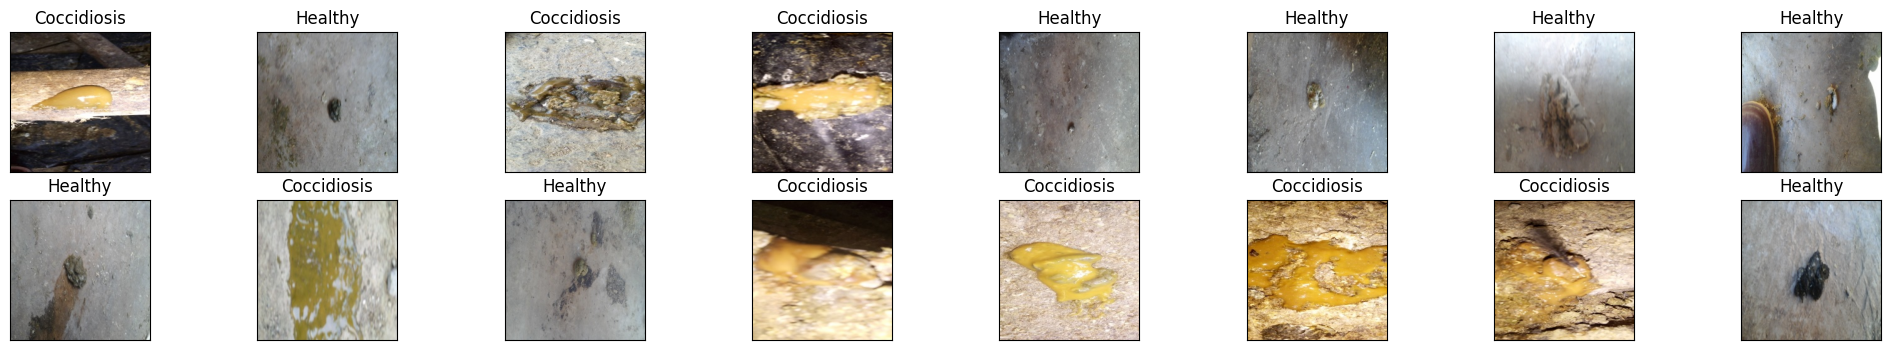

In [22]:
#Visualize some sample data
import matplotlib.pyplot as plt
import numpy as np
classes = ['Coccidiosis', 'Healthy']
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [ ]:
torch.load('artifacts/training/trained_model.pt')